In [1]:
import os
from sys import getsizeof
from time import sleep
import pickle
import json
import re
import inspect
from warnings import filterwarnings

import numpy as np
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import (
	BartTokenizer, BartForConditionalGeneration,
	T5Tokenizer, T5ForConditionalGeneration,
	PegasusForConditionalGeneration, PegasusTokenizerFast,
	GPT2TokenizerFast
)
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv

from utils.helpers import *
from utils.encoders import *
from utils.pipelines import *
from utils.trainer_utils import *
from utils.evaluator_utils import *

def plot_histogram(data):
	bins = int(len(data) ** .5)
	plt.hist(data, bins=bins)
	plt.show()

inf = float("inf")
filterwarnings("ignore")
device = get_device(500)
load_dotenv()

True

In [2]:
model_name = "pegasus"

data_dir = "/Users/naman/Workspace/Data/Long-Document-Summarization"
data_dir = "/home/nchibbar/Data"

sent_dir = f"{data_dir}/Models/Sent-Transformer"
bart_dir = f"{data_dir}/Models/BART"
t5_dir = f"{data_dir}/Models/T5"
pegasus_dir = f"{data_dir}/Models/PEGASUS"
gpt_dir = f"{data_dir}/Models/GPT-3.5-turbo-tokenizer"

govreport_dir = f"{data_dir}/GovReport/processed"
bigpatent_dir = f"{data_dir}/BigPatent/processed"
govreport_files = os.listdir(govreport_dir)
bigpatent_files = os.listdir(bigpatent_dir)

len(govreport_files), len(bigpatent_files)

(7238, 2856)

In [3]:
# Sentence transformer
# Automatically loads into gpu if available
sent_encoder = SentenceTransformer(sent_dir, device=device)

match model_name:

	case "bart":
		tokenizer = BartTokenizer.from_pretrained(bart_dir)
		model = BartForConditionalGeneration.from_pretrained(bart_dir)
		context_size = model.config.max_position_embeddings

	case "t5":
		tokenizer = T5Tokenizer.from_pretrained(t5_dir)
		model = T5ForConditionalGeneration.from_pretrained(t5_dir)
		context_size = model.config.n_positions

	case "pegasus":
		tokenizer = PegasusTokenizerFast.from_pretrained(pegasus_dir)
		model = PegasusForConditionalGeneration.from_pretrained(pegasus_dir)
		context_size = model.config.max_position_embeddings

	case "gpt":
		tokenizer = GPT2TokenizerFast.from_pretrained(gpt_dir)
		model = "gpt-3.5-turbo"
		context_size = 4096

context_size

512

In [4]:
preprocessor = TextProcessor(preprocessing=True)
postprocessor = None

## BigPatent

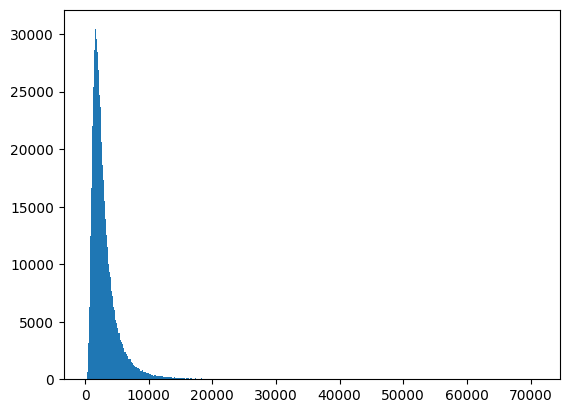

In [5]:
word_counts = []
for file in bigpatent_files:
	file_path = f"{bigpatent_dir}/{file}"
	with open(file_path) as fp:
		data = json.load(fp)
	for text in data["texts"]:
		word_counts.append(count_words(text))

plot_histogram(word_counts)

In [7]:
max(word_counts), np.mean(word_counts), len(word_counts)

(71027, 3055.7211252443412, 1341362)

In [ ]:
sum([
	1
	for count in word_counts
	if count > 40_000
])

## Rough

In [5]:
min_words = 20_000
max_words = inf
max_texts = inf
texts, summaries = [], []
num_texts = 0
for file in govreport_files:
	file_path = f"{govreport_dir}/{file}"
	with open(file_path) as fp:
		data = json.load(fp)
	if min_words < count_words(data["text"]) < max_words:
		texts.append(data["text"])
		summaries.append(data["summary"])
		num_texts += 1
	if num_texts == max_texts:
		break

num_texts

317

In [6]:
segment_min_words = 20
text_segmenter = TextSegmenter(nltk.sent_tokenize, segment_min_words)
keywords_preprocessor = TextProcessor(
	only_words_nums = True,
	remove_nums = True
)
stop_words = get_stop_words(extra_stop_words=STOP_WORDS)
len(stop_words)

392

In [7]:
min_tokens_frac = .5
min_summary_tokens = 300
head_size = .5
threshold = .7
boost = .03
num_keywords = 20
seed = 69
system_prompt = "You will be given some segments of a very long document. Your task is to summarize the entire document as a whole by extracting key information and ideas from the segments. Generate a detailed, concise, and coherent summary in 300 words. Do not refer to the document in the summary in any way."

temperature = 2.
repetition_penalty = 3.
top_p = .95

encoders = [
	TruncateMiddle(
		tokenizer, context_size, 1, preprocessor
	),
	TruncateMiddle(
		tokenizer, context_size, head_size, preprocessor, True
	),
	UniformSampler(
		tokenizer, min_tokens_frac * context_size, context_size,
		text_segmenter, preprocessor, True, seed
	),
	SegmentSampler(
		tokenizer, min_tokens_frac * context_size, context_size,
		text_segmenter, sent_encoder, preprocessor, threshold, boost, seed
	),
	RemoveRedundancy(
		tokenizer, min_tokens_frac * context_size, context_size,
		text_segmenter, sent_encoder, preprocessor, threshold, seed
	),
	KeywordScorer(
		tokenizer, context_size, text_segmenter, sent_encoder,
		preprocessor, num_keywords, keywords_preprocessor, stop_words
	)
]

pipelines = [
	SummarizationPipeline(
		model, enc, postprocessor, min_summary_tokens,
		context_size, device, temperature, repetition_penalty, top_p
	) for enc in encoders
] if model_name != "gpt" else [
	OpenAIPipeline(
		model, enc, postprocessor, system_prompt
	) for enc in encoders
]

In [8]:
processed_texts = preprocessor(texts)
threshold = .5
num_segments_found = []
for text in processed_texts:
	num_segments = 0
	keywords = get_keywords(text, 20, stop_words, keywords_preprocessor)
	keywords = " ".join(keywords)
	keyword_emb = sent_encoder.encode(keywords)
	segments = text_segmenter(text)
	segment_embs = sent_encoder.encode(segments)
	for segment, embedding in zip(segments, segment_embs):
		score = keyword_emb @ embedding
		if score > threshold:
			num_segments += 1
	num_segments_found.append(num_segments)

In [9]:
np.sort(num_segments_found)

array([ 17,  21,  26,  27,  31,  31,  32,  32,  36,  36,  39,  39,  44,
        46,  49,  51,  51,  52,  53,  54,  56,  57,  57,  57,  58,  59,
        60,  62,  62,  65,  65,  68,  75,  75,  76,  82,  82,  87,  87,
        87,  89,  91,  92,  92,  94,  94,  95,  95,  95,  95,  95,  96,
        96,  97,  97,  99, 100, 101, 102, 102, 103, 103, 105, 105, 105,
       108, 109, 110, 111, 112, 115, 117, 118, 119, 120, 124, 125, 126,
       126, 128, 129, 130, 131, 132, 133, 134, 134, 135, 135, 135, 136,
       139, 140, 141, 146, 146, 147, 148, 148, 148, 149, 149, 150, 151,
       151, 153, 153, 154, 155, 155, 156, 156, 157, 158, 158, 160, 160,
       162, 162, 165, 167, 167, 168, 169, 170, 171, 171, 172, 172, 173,
       173, 174, 174, 175, 176, 177, 177, 177, 178, 178, 179, 179, 179,
       180, 180, 181, 182, 182, 182, 183, 184, 184, 185, 185, 186, 186,
       187, 188, 190, 191, 192, 196, 197, 199, 203, 204, 206, 206, 206,
       207, 207, 207, 209, 211, 212, 214, 215, 215, 215, 215, 21

In [ ]:
with open(f"{data_dir}/pegasus-govreport.pkl", "rb") as fp:
	results = pickle.load(fp)
scores = results["scores"]
sort1, sort2, sort3 = results["sort1"], results["sort2"], results["sort3"]
gen_summaries = results["gen_summaries"]
scores[0][sort1]

In [ ]:
ind = 0
problem_text = results["texts"][sort1[ind]]
print(gen_summaries[sort1[ind]])

In [ ]:
print(pipelines[-1](problem_text))

In [ ]:
enc = encoders[-1](problem_text, return_batch=False)
sent = tokenizer.decode(enc, skip_special_tokens=True)
print(sent)

In [ ]:
processed_problem = preprocessor(problem_text)
segments = text_segmenter(processed_problem)
segments

In [ ]:
print(results["summaries"][sort1[ind]])